In [3]:
import pandas as pd

data = pd.read_csv(
    "https://raw.githubusercontent.com/opendp/cs208/main/spring2022/data/FultonPUMS5full.csv")

In [4]:
from stat_mean import *

def simulate(data, column_name, bounds, epsilon, percentile, n_sims):
    history = []
    for puma, subdata in data.groupby("puma"):
        target_data = subdata[column_name]

        for _ in range(n_sims):
            trimmed_mean = release_dp_trimmed_mean(
                target_data, percentile, bounds, epsilon)

            percentile_mean, p_lower, p_upper = release_dp_percentile_mean(
                target_data, percentile, bounds, epsilon)
        
            winsorized_mean, *_ = release_dp_winsorized_mean(
                target_data, percentile, bounds, epsilon)

            history.append({
                "puma": puma,
                "dp_mean": release_dp_mean(target_data, bounds, epsilon),
                "dp_trimmed_mean": trimmed_mean,
                "dp_percentile_mean": percentile_mean,
                "dp_winsorized_mean": winsorized_mean,
                "p_lower": p_lower,
                "p_upper": p_upper
            })

    return pd.DataFrame(history)


import seaborn as sns
import matplotlib.pyplot as plt
from typing import List


def build_boxplot(
    data: pd.DataFrame, 
    column_name: str, 

    history: pd.DataFrame, 
    algorithm_names: List[str], 

    percentile: int = None):
    """Builds a boxplot for comparing dp mean releases on PUMS.
    The red dots are exact estimates of the mean on `column_name`.

    If `percentile` is passed, history should also contain "p_lower" and "p_upper" columns of dp percentile estimates.
    If `percentile` is passed, blue (average DP estimate) and red (exact estimate) points are shown.

    :param data: PUMS dataset, as-is.
    :param column_name: Name of the column the mean is computed on.
    :param history: pd.DataFrame consisting of a "puma" column, and `algorithm_names` columns.
    :param algorithm_names: List of algorithms to plot.
    :param percentile: Option[int]
    """
    ## MAIN BOXPLOT
    melted = history.melt(
        id_vars="puma", value_vars=algorithm_names, 
        var_name="algorithm", value_name="mean estimate")

    exact_means = data.groupby("puma")[column_name].mean()
    exact_means.name = "mean"
    order = exact_means.sort_values().index

    sns.set(rc = {'figure.figsize':(15,8)})
    sns.boxplot(data=melted, 
        x="puma", y="mean estimate", hue="algorithm", 
        order=order, ax=plt.gca())

    ## EXTRA DATA POINTS
    def plot_points(series, color):
        sns.pointplot(x=series.index, y=series.values, 
            order=order, ax=plt.gca(), kind="point", linestyles='', color=color, scale=1.5)

    # plot exact means in RED
    plot_points(exact_means, "tab:red")

    if percentile is not None:
        # plot exact percentiles in RED
        exact_p_lower = data.groupby("puma")[column_name].quantile(percentile / 100 / 2)
        exact_p_lower.name = "p_lower_exact"
        plot_points(exact_p_lower, "tab:red")
        exact_p_upper = data.groupby("puma")[column_name].quantile(1 - percentile / 100 / 2)
        exact_p_upper.name = "p_upper_exact"
        plot_points(exact_p_upper, "tab:red")

        # average estimated percentiles in BLUE
        avg_lower = history.groupby("puma")['p_lower'].mean()
        avg_lower.name = "avg_lower"
        plot_points(avg_lower, "tab:blue")
        avg_upper = history.groupby("puma")['p_upper'].mean()
        avg_upper.name = "avg_upper"
        plot_points(avg_upper, "tab:blue")

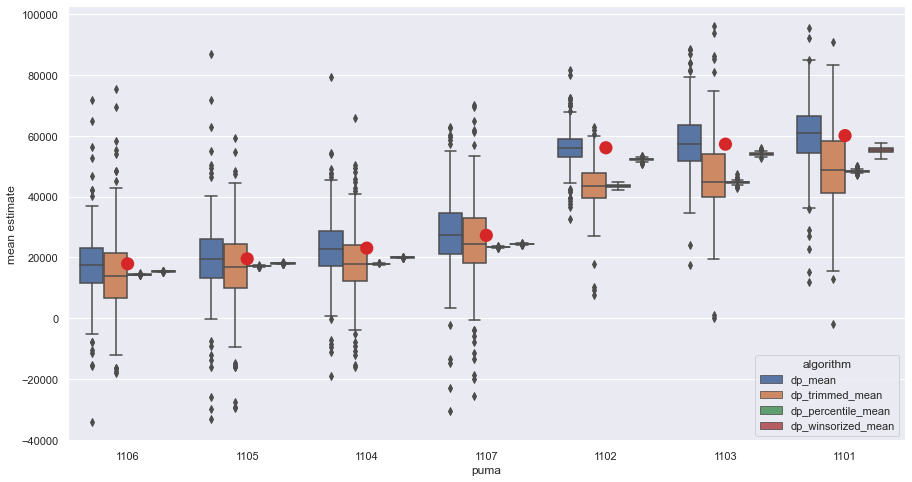

In [7]:
target_column = "income"
percentile = 10
history = simulate(
    data,
    target_column, 
    bounds=(0., 3e7), 
    epsilon=1, 
    percentile=percentile, 
    n_sims=200)

algorithm_names = [
    "dp_mean", 
    "dp_trimmed_mean", 
    "dp_percentile_mean", 
    "dp_winsorized_mean"
]

# pass percentile to see percentile estimates
build_boxplot(
    data, target_column,
    history, algorithm_names,
    percentile=None)

In [8]:
def rmse(a, b):
    return np.sqrt(((a - b) ** 2).sum() / len(a))    


exact_means = data.groupby("puma")[target_column].mean()
exact_means.name = "mean"
history = history.join(exact_means, on="puma")
print("dp mean error:           ", rmse(history['mean'], history['dp_mean']))
print("dp trimmed mean error:   ", rmse(history['mean'], history['dp_trimmed_mean']))
print("dp percentile mean error:", rmse(history['mean'], history['dp_percentile_mean']))
print("dp winsorized mean error:", rmse(history['mean'], history['dp_winsorized_mean']))

dp mean error:            11931.979642121813
dp trimmed mean error:    15465.115942581127
dp percentile mean error: 8564.148431946636
dp winsorized mean error: 3294.492375721872
